<div style="background-color: #00FF00; padding: 20px;">
    <p style='text-align:center;
              font-family: sans-serif;
              font-weight:bold;
              color:black;
              font-size:50px;
              margin: 5px;'> 
        <font color='blue'; size='7'>Anomaly Detection</font>
    </p>
    <p style="text-align:center;
              font-family: sans-serif;
              font-weight:bold;
              color:tomato;
              font-size:30px;
              margin: 10px;">
        Fraud Detection - GAN model
    </p>
</div>

<h1 style="text-align: center; color: WHITE; font-size:30px; background-color: #00FF00; padding: 10px; border-radius: 5px;">
    Project Workflow
</h1>

### 1. Data Preparation
   - Load data
   - Inspect Class Imbalance
   - Split the data into train and test sets

### 2. Data Preprocessing
   - Balance the training data (Use SMOTE)
   - Data Scaling
   - Feature Reduction: PCA

### 3. Model Building
   - Define GAN c    omponents:
	- Build the `gan`, `generator`, and `discriminator` models.
   - Train the GAN model

### 4. Model Evaluation
   - Evaluate the model on the imbalanced test data
 : - Model metris: Calculate ROC AUC, classification report, and other relevant metrics.
  
### 4. Model Deolyment
   - save the trained models
   - Deploy the saved models
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, recall_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the data
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Inspect Class Ratio 
class_ratio = df['Class'].value_counts(normalize=True)
print("class_ratio in the dataframe:", class_ratio)

# Balance the class ratio
X = df.drop('Class', axis=1)
y = df['Class']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Count the class distribution in the training set prior to Balancing
train_class_ratio = y_train.value_counts(normalize=True)
print("\nTraining set class distribution prior to Balancing:")
print(train_class_ratio)

# Count the class distribution in the test set
test_class_ratio = y_test.value_counts(normalize=True)
print("\nTest set class distribution:")
print(test_class_ratio)

# Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Count the class distribution in the training set After Balancing
train_class_ratio = y_train_res.value_counts(normalize=True)
print("\nTraining set class distribution After Class Balancing:")
print(train_class_ratio)

# Feature Reduction and PCA
# Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("len X_train_scaled: ", len(X_train_scaled) ) 
print("len X_test_scaled: ", len(X_test_scaled) ) 

class_ratio in the dataframe: Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Training set class distribution prior to Balancing:
Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64

Test set class distribution:
Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64

Training set class distribution After Class Balancing:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64
len X_train_scaled:  398040
len X_test_scaled:  85443


In [4]:
# Build GAN Model

# Apply PCA
input_dim = 8
pca = PCA(n_components=input_dim)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define GAN Models
def build_gan():
    # Generator Model
    generator = Sequential([
        Dense(32, input_dim=input_dim),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dense(64),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dense(input_dim, activation='tanh')  
    ])

    # Discriminator Model
    discriminator = Sequential([
        Dense(64, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dense(32),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])

    # Compile Discriminator
    discriminator.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Compile GAN Model
    gan = Sequential([generator, discriminator])
    discriminator.trainable = False
    gan.compile(optimizer=Adam(), loss='binary_crossentropy')

    return gan, generator, discriminator

# Train the GAN model using the training data
def train_gan(gan, generator, discriminator, X_train_pca, y_train, epochs, batch_size):
    history = {'d_loss_real': [], 'd_loss_fake': [], 'g_loss': []}
    
    for epoch in range(epochs):
        for _ in range(X_train_pca.shape[0] // batch_size):
            noise = tf.random.normal([batch_size, input_dim])
            generated_data = generator.predict(noise)
            
            idx = np.random.randint(0, X_train_pca.shape[0], batch_size)
            real_data = X_train_pca[idx]
            
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))
            
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_data, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
            
            history['d_loss_real'].append(d_loss_real[0])
            history['d_loss_fake'].append(d_loss_fake[0])
        
        noise = tf.random.normal([batch_size, input_dim])
        valid_y = np.ones((batch_size, 1))
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, valid_y)
        
        history['g_loss'].append(g_loss)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Discriminator Real Loss: {d_loss_real[0]:.4f}, Discriminator Fake Loss: {d_loss_fake[0]:.4f}")
        print(f"  Generator Loss: {g_loss}")
        print("")

    return history

# Build and train the GAN
gan, generator, discriminator = build_gan()
history = train_gan(gan, generator, discriminator, X_train_pca, y_train, epochs=25, batch_size=64)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/25
  Discriminator Real Loss: 0.6570, Discriminator Fake Loss: 0.6608
  Generator Loss: [array(0.66080475, dtype=float32), array(0.66080475, dtype=float32), array(0.4546875, dtype=float32)]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 2/25
  Discriminator Real Loss: 0.

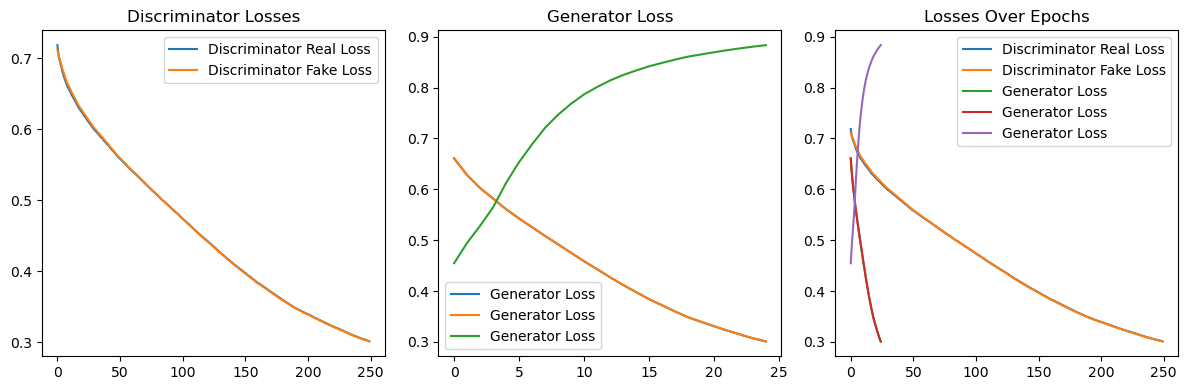

In [5]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history['d_loss_real'], label='Discriminator Real Loss')
plt.plot(history['d_loss_fake'], label='Discriminator Fake Loss')
plt.legend()
plt.title('Discriminator Losses')

plt.subplot(1, 3, 2)
plt.plot(history['g_loss'], label='Generator Loss')
plt.legend()
plt.title('Generator Loss')

plt.subplot(1, 3, 3)
plt.plot(history['d_loss_real'], label='Discriminator Real Loss')
plt.plot(history['d_loss_fake'], label='Discriminator Fake Loss')
plt.plot(history['g_loss'], label='Generator Loss')
plt.legend()
plt.title('Losses Over Epochs')

plt.tight_layout()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


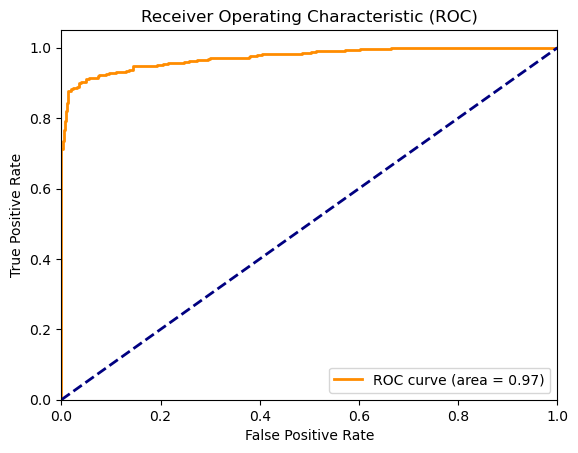

In [6]:
# Evaluate GAN performance on the test set
# Generate data with the trained generator
noise = tf.random.normal([X_test_pca.shape[0], input_dim])
generated_data = generator.predict(noise)

# Combine real and fake data
combined_data = np.concatenate([X_test_pca, generated_data])
labels = np.concatenate([np.ones(X_test_pca.shape[0]), np.zeros(generated_data.shape[0])])

# Evaluate the discriminator
discriminator_predictions = discriminator.predict(combined_data).flatten()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, discriminator_predictions)
roc_auc = roc_auc_score(labels, discriminator_predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [7]:
# Find the best threshold
best_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"Best Threshold: {best_threshold:.2f}")

# Compute metrics at the best threshold
predicted_labels = [1 if p >= best_threshold else 0 for p in discriminator_predictions]

f1 = f1_score(labels, predicted_labels)
accuracy = accuracy_score(labels, predicted_labels)
precision = average_precision_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)

print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Best Threshold: 0.49
F1 Score: 0.928
Accuracy: 0.932
Precision: 0.925
Recall: 0.878


<h1 style="text-align: center; color: WHITE; font-size:30px; background-color: #00FF00; padding: 10px; border-radius: 5px;">
    Comments
</h1>



- **Best Threshold: 0.49**: This threshold is close to 0.5, indicating tha tthe model is close to the standard decision boundarl.

- **F1 Score: 0.928**: The F1 Score is a harmonic mean of precision and recall. A score of 0.928 is excellent and indicates a strong balance between precision and recall.

- **Accuracy: 0.932**: Accuracy of 93.2%  meastthe your model correctly classifies 93.2% of the instances. This is quite high angests d sugyour model performs well overall.

- **Precision: 0.925**: Precision of 92.5% mat eansn your model predicts a positive class, it is correct 92.5% of the time. This is also very high, indicating that false positives are relatively rare.

- **Recall: 0.878**: Recall oeans that f 87hat your model correctly identifies 87.8% of the actual positive instances. While this is slightly lower than precision, it is still quite high ates indicthe hat your model is good at capturing most of the positive in
<h3>Judgement</h3>
Overall, the model appears to be in very good shape.<br> 
 It performed well in terms of precision, recall, and overall balance, as indicated by the F1 score.
l trade-offs.